# Quantum-enhanced support vector machines

A Support Vector Machine (SVM) is a supervised learning algorithm that aims to find a hyperplane in an N-dimensional space (where N is the number of features) that distinctly separates data points belonging to different classes. The optimal hyperplane is the one that maximizes the margin between the classes.

The original formulation of SVM only allows classifying linearly separable data. To tackle more complex problems, the *kernel trick* is usually used. The kernel trick is a mathematical technique used in SVMs to transform input data into a higher-dimensional space. This transformation allows the SVM to find a hyperplane that can separate nonlinearly separable data in the original feature space. Kernels are functions that compute the dot product of the transformed data without explicitly calculating the transformation, saving computational resources.


$$
K(x_i, x_j) = <\phi(x_i), \phi(x_j)>
$$


<div align="center">
<img src="https://github.com/laiadc/QML/blob/main/QSVM%20tutorial/KernelSVM.PNG?raw=1" alt="Kernel Support Vector Machines" />
</div>

Quantum computing can be used to find useful representations of data samples, by creating *quantum kernels.* These quantum kernels enable the processing of information in a quantum parallelism, potentially providing advantages in scenarios with large datasets or complex non-linear relationships between features. Given a data sample $x_i$, we would encode it in a quantum circuit as:

$$
x_i \longrightarrow \ket{x_i} = U(x_i)\ket{0}^{\otimes n}
$$

Then, the quantum kernel between two data points $x_i$, $x_j$ is

$$
K(x_i, x_j) = \bra{x_i}\ket{x_j} = \bra{0}^{\otimes n} U^\dag(x_i)U(x_j)\ket{0}^{\otimes n}
$$

<div align="center">
<img src="https://github.com/laiadc/QML/blob/main/QSVM%20tutorial/QSVM.PNG?raw=1" alt="Quantum enhanced Support Vector Machines" />
</div>

In this notebook, we will explore examples of quantum enhanced support vector machines. The task will be to classify a breast cancer dataset. Let's start by loading the needed packages.

Run the following three cells if you are using Google Colab

In [1]:
!git clone https://github.com/laiadc/QML.git

Cloning into 'QML'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 85 (delta 0), reused 2 (delta 0), pack-reused 81 (from 1)
Receiving objects: 100% (85/85), 18.63 MiB | 8.69 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Updating files: 100% (19/19), done.


In [2]:
cd QML/QSVM\ tutorial

/content/QML/QSVM tutorial


In [ ]:
pip install -r requirements.txt

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np

## Breast cancer dataset

Let's start by loading the dataset from `sklearn`.

In [5]:
# First the dataset must be imported.
dataset = datasets.load_breast_cancer()
print('Dataset shape:', dataset.data.shape)
print('Dataset features:', dataset.feature_names)

Dataset shape: (569, 30)
Dataset features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


The dataset contains 30 features related to the tumor state. These features provide useful information to predict the target (`Benign/Malignant`).

## Processing

The first step is to process the raw dataset. We split the data into training, validation and test sets. Remember that the training set is used to train the model, the validation set is used to evaluate different predictive models and select the most optimal one, and the test set provides an estimation of the final performance.

Also, to reduce the time complexity of the quantum algorithms, we select a maximum number of data samples.

In [6]:
num_samples_train = 50
num_samples_test = 50

# Divide the data into training, valiation and test. The training data will have a given number of samples, the rest is divided into validation and test
X_train, X_val, y_train, y_val = train_test_split(dataset.data, dataset.target, test_size=dataset.target.shape[0] - num_samples_train, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

#Select the given number of samples
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
X_val = X_val[:num_samples_test]
y_val = y_val[:num_samples_test]

## Dimensionality reduction

Training a quantum-enhanced SVM with 30 features will require several computational resources (simulating quantum algorithms in classical computers is hard!). For this reason, we reduce the number of features by using Principal Component Analysis (PCA). The main goal of PCA is to transform a high-dimensional dataset into a lower-dimensional space while retaining as much of the original variability as possible.

In PCA, the algorithm identifies the principal components, which are linear combinations of the original features. These components are ordered by the amount of variance they capture in the data. The first principal component explains the most variance, the second explains the second most, and so on. By choosing a subset of the principal components, one can create a lower-dimensional representation of the data that retains the most important information.

Let's apply PCA to our dataset

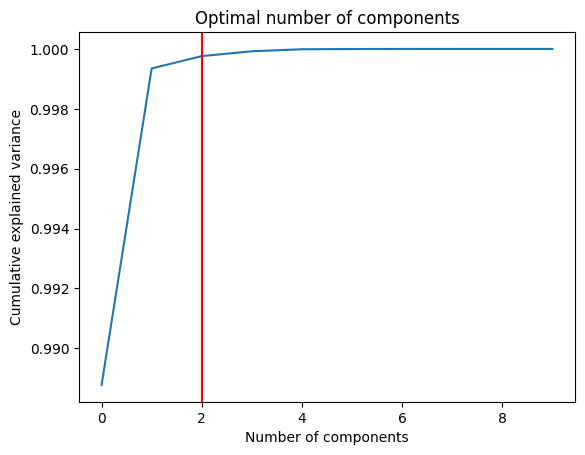

In [9]:
n = 10
# Apply PCA to reduce the number of qubits
pca = PCA(n_components=n).fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=2, color='r')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Optimal number of components')
plt.show()

In [10]:
np.cumsum(pca.explained_variance_ratio_)

tensor([0.988779  , 0.99934782, 0.99975947, 0.99992171, 0.99998888,
        0.99999608, 0.9999993 , 0.99999963, 0.99999986, 0.99999996], requires_grad=True)

The previous plot shows the cumulative variance explained by adding PCA components. We can see that the first component already explains 98.9% of the total variability, and with a second component we explain more than 99.9% of the total variance. Thberefore, two components are enough to train a classification model. Let's apply PCA with only 2 components.

In [11]:
n = 2
# Apply PCA to reduce the number of qubits
pca = PCA(n_components=n).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

## Data scaling

The last step will be to scale the data to the $[0,1]$ domain. This will make it easier to encode the data into quantum states.

In [12]:
# Scale samples to [0,1]
scaler = MinMaxScaler((0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Make sure that inputs are in [0,1] domain for validation/test
X_val_scaled[X_val_scaled<0] = 0
X_val_scaled[X_val_scaled>1] = 1
X_test_scaled[X_test_scaled<0] = 0
X_test_scaled[X_test_scaled>1] = 1


## Visualize the data

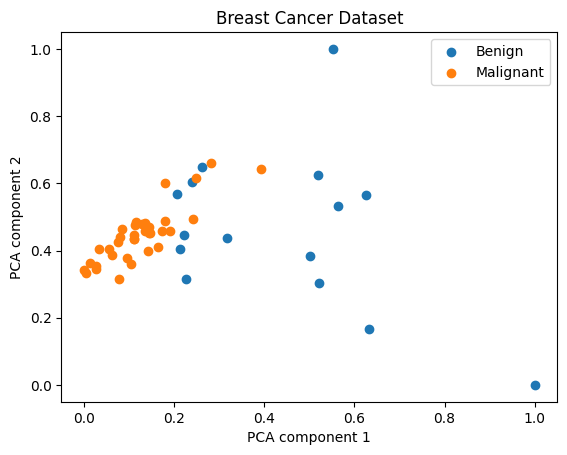

In [13]:
x_axis_data = X_train_scaled[y_train == 0, 0]
y_axis_data = X_train_scaled[y_train == 0, 1]
plt.scatter(x_axis_data, y_axis_data, label='Benign')

x_axis_data = X_train_scaled[y_train == 1, 0]
y_axis_data = X_train_scaled[y_train == 1, 1]
plt.scatter(x_axis_data, y_axis_data, label='Malignant')

plt.title("Breast Cancer Dataset")
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend()
plt.show()

We can see that the first component already classifies most of the data samples.

## Defining the quantum kernel

Now we will use Pennylane to define our quantum kernel. We will use Angle Embedding as our quantum circuit.

To implement the kernel we prepare the two states $U(x_i)\ket{0}^{\otimes n}$, and measure the overlap with $x_j$ by applying the inverse embedding  $U(x_j)$. We then measure the projector onto the initial state $\ket{0\cdots 0}\bra{0 \cdots 0}$

<div align="center">
<img src="https://github.com/laiadc/QML/blob/main/QSVM%20tutorial/KernelQC.PNG?raw=1" alt="Calculating the kernel with quantum circuits" />
</div>

In [14]:
nqbits = 2

dev = qml.device("default.qubit", wires=nqbits, shots=None)

def ansatz(x):
    """The quantum kernel."""
    qml.templates.AngleEmbedding(x*2*np.pi, wires=range(nqbits))

adjoint_ansatz = qml.adjoint(ansatz)


@qml.qnode(dev, interface="autograd")
def kernel_circuit(x1, x2):
    ansatz(x1)
    adjoint_ansatz(x2)
    return qml.probs(wires=list(range(nqbits)))

def kernel(x1, x2):
    return kernel_circuit(x1, x2)[0]


Let's visualize the ansatz

The kernel value between the first and second datapoint is 0.116


(<Figure size 500x300 with 1 Axes>, <Axes: >)

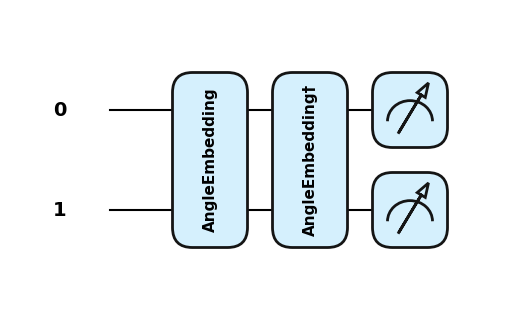

In [16]:
kernel_value = kernel(X_train[0], X_train[1])
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

qml.draw_mpl(kernel_circuit, elevel="device", style="pennylane")(X_train[0], X_train[1])


Let's take a look at the kernel matrix

In [17]:
K= qml.kernels.square_kernel_matrix(X_train_scaled, kernel, assume_normalized_kernel=True)

with np.printoptions(precision=3, suppress=True):
    print(K)

[[1.    0.14  0.373 ... 0.87  0.21  0.424]
 [0.14  1.    0.899 ... 0.351 0.797 0.858]
 [0.373 0.899 1.    ... 0.633 0.87  0.978]
 ...
 [0.87  0.351 0.633 ... 1.    0.38  0.715]
 [0.21  0.797 0.87  ... 0.38  1.    0.758]
 [0.424 0.858 0.978 ... 0.715 0.758 1.   ]]


## Train the SVM modle with the quantum kernel

Now, let's train the *classical* SVM model by giving it the kernel matrix that we calculated with our quantum embedding.

In [18]:
from sklearn.svm import SVC
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, kernel)).fit(X_train_scaled, y_train)

## Evaluate the model

Let's calculate the accuracy in the classification problem.

In [19]:
def accuracy(classifier, X, Y_target):
    y_pred = classifier.predict(X)
    acc =  1 - np.count_nonzero( y_pred - Y_target) / len(Y_target)
    return acc, y_pred


accuracy_val, y_val_pred= accuracy(svm, X_val_scaled, y_val)
print(f"The accuracy of the kernel in the validation set is {accuracy_val:.3f}")

accuracy_test, y_test_pred = accuracy(svm, X_test_scaled, y_test)
print(f"The accuracy of the kernel in the test set is {accuracy_test:.3f}")

The accuracy of the kernel in the validation set is 0.960
The accuracy of the kernel in the test set is 0.960


## Visualize the results

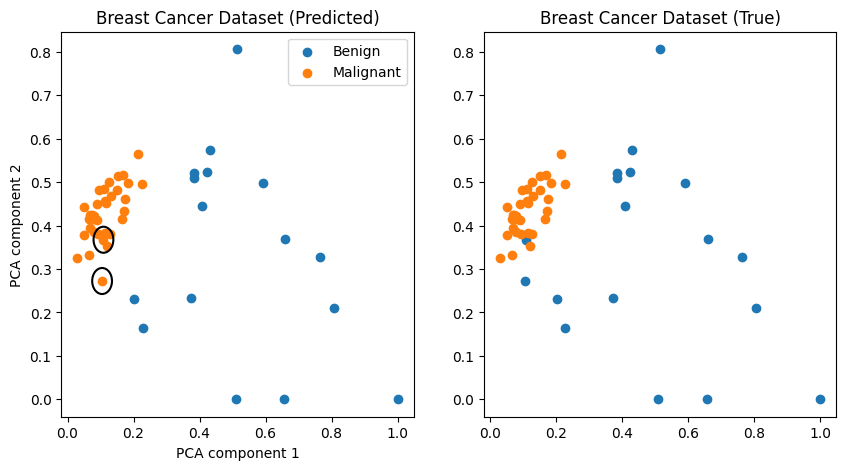

In [20]:
idx_misscls = np.arange(y_test.shape[0])[y_test_pred != y_test]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
x_axis_data = X_test_scaled[y_test_pred == 0, 0]
y_axis_data = X_test_scaled[y_test_pred == 0, 1]
ax1.scatter(x_axis_data, y_axis_data, label='Benign')

x_axis_data = X_test_scaled[y_test_pred == 1, 0]
y_axis_data = X_test_scaled[y_test_pred == 1, 1]
ax1.scatter(x_axis_data, y_axis_data, label='Malignant')

for idx in idx_misscls:
    circle = plt.Circle(X_test_scaled[idx,:], 0.03, color='black', fill=False, linewidth=1.5)
    ax1.add_patch(circle)

x_axis_data = X_test_scaled[y_test == 0, 0]
y_axis_data = X_test_scaled[y_test == 0, 1]
ax2.scatter(x_axis_data, y_axis_data, label='Benign')

x_axis_data = X_test_scaled[y_test == 1, 0]
y_axis_data = X_test_scaled[y_test == 1, 1]
ax2.scatter(x_axis_data, y_axis_data, label='Malignant')

ax1.set_title("Breast Cancer Dataset (Predicted)")
ax2.set_title("Breast Cancer Dataset (True)")
ax1.set_xlabel('PCA component 1')
ax1.set_ylabel('PCA component 2')
ax1.legend()
plt.show()

You can see that our quantum-enhanced SVM does a great job at classifying this dataset.

## Exercise: Compare with a linear kernel

Compare the performance of our quantum kernel with angle embedding with the classical linear kernel.

In [ ]:
# Your code here


accuracy_val_class,y_val_pred_class = accuracy(svm_classical, X_val_scaled, y_val)
print(f"The accuracy of the kernel in the validation set is {accuracy_val_class:.3f}")

accuracy_test_class, y_test_pred_class = accuracy(svm_classical, X_test_scaled, y_test)
print(f"The accuracy of the kernel in the test set is {accuracy_test_class:.3f}")

The accuracy of the kernel in the validation set is 0.780
The accuracy of the kernel in the test set is 0.800


## Exercise: Create a kernel with repeated amplitude encoding

Test the performance of the quantum kernel with $d$ dimensions, and find the optimal value of $d=1,2,\cdots$

## Exercise: Test other quantum embeddings

You can check the different Pennylane templates for quantum embeddings (https://docs.pennylane.ai/en/stable/introduction/templates.html) or the common ZZFeature map (https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap)

## Training the quantum kernel

Until now, the kernels that we studied had no training parameters. To further increase the power of quantum kernels, we can design *variational quantum kernels*, which need to be optimized to find the best solution. We will look at this example, which is adapted from the Qiskit tutorial (https://qiskit-community.github.io/qiskit-machine-learning/tutorials/08_quantum_kernel_trainer.html)

There are many ways to optimize the quantum kernel. In this example, we will use the Quantum Kernel Alignment introduced in  this paper: https://arxiv.org/abs/2105.03406
The key idea is to solve the standard classical formulation of SVM (without kernel) and then use the obtained parameters to find the best fitting for the quantum kernel. This approach can be seen as optimizing the
SVM upper bound on the generalization error directly. The cost function that we minimize is

$$
F(\theta) = \sum_i \alpha_i - 1/2 \sum_{ij} \alpha_i\alpha_jy_iy_jK_\theta(x_i,x_j)
$$

where $\alpha_i$ are the optimal Lagrange multipliers found by solving the standard SVM quadratic program, and $\theta$ is the parameter that we want to optimize.

Let's apply this algorithm to our dataset. We begin by importing the needed libraries.

In [22]:
# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
import sklearn
import matplotlib

## Create quantum ansatz

Let's define the quantum ansatz by applying a rotation layer and the ZZFeatureMap (commonly used in Qiskit to encode data samples).

Trainable parameters: θ, ['θ[0]']


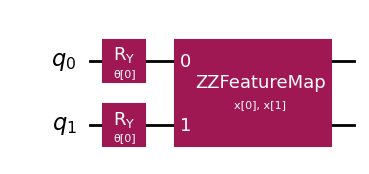

In [23]:
# Create a rotational layer to train. We will rotate each qubit the same amount.
training_params = ParameterVector("θ", 1)
qc = QuantumCircuit(2)
qc.ry(training_params[0], 0)
qc.ry(training_params[0], 1)

# Use ZZFeatureMap to represent input data
fm = ZZFeatureMap(2)

# Create the feature map, composed of our two circuits
qc = qc.compose(fm)

print(f"Trainable parameters: {training_params}")
qc.draw('mpl', style="iqp")

Now let's train the quantum kernel to maximize kernel alignment. Luckily, Qiskit already has a `TrainableFidelityQuantumKernel` and a `QuantumKernelTrainer` functions that will make this process very easy. The `QKTCallback` function will allow us to visualize the training process.

In [24]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

In [25]:
# Instantiate quantum kernel
quant_kernel = TrainableFidelityQuantumKernel(feature_map=qc, training_parameters=training_params)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=6, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)

Now let's train the quantum kernel. It may take some minutes to train.

In [26]:
# Train the kernel using QKT directly
qka_results = qkt.fit(X_train_scaled, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_circuit': None,
    'optimal_parameters': {ParameterVectorElement(θ[0]): 1.6114268623279937},
    'optimal_point': array([1.61142686]),
    'optimal_value': 19.755863290978922,
    'optimizer_evals': 18,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7ce4c26baf10>}


Now, we can visualize the training process and also the final learnt kernel matrix.

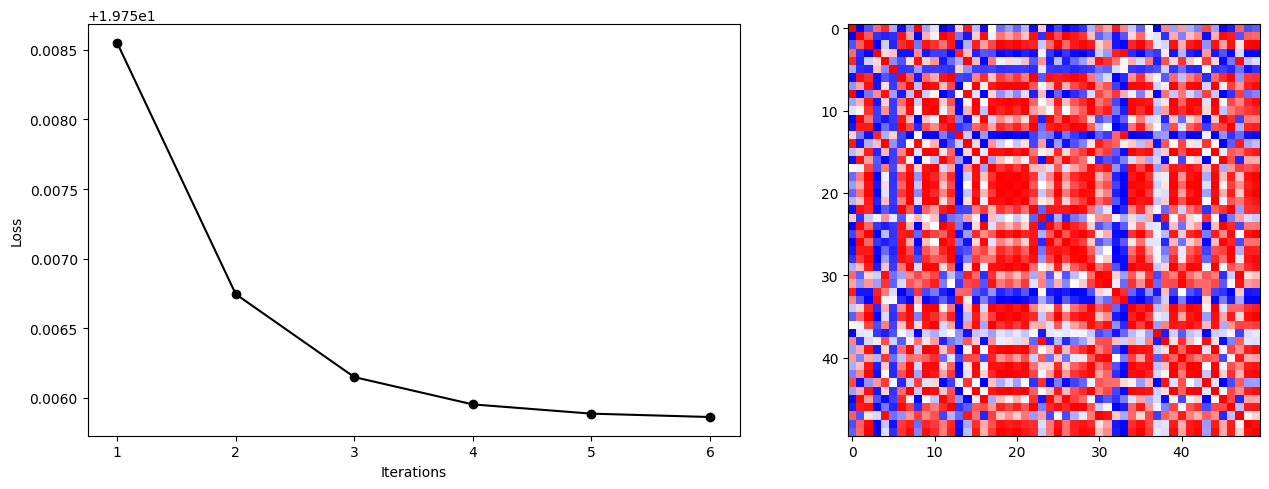

In [27]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train_scaled)  # kernel matrix evaluated on the training samples

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=matplotlib.colormaps["bwr"])
fig.tight_layout()
plt.show()

Finally, let's evaluate the performance of our quantum kernel.

In [28]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(X_train_scaled, y_train)

# Evalaute validation accuracy
y_val_pred = qsvc.predict(X_val_scaled)
accuracy_val = sklearn.metrics.balanced_accuracy_score(y_true=y_val, y_pred=y_val_pred)
print(f"Accuracy Validation: {accuracy_val}")

# Evalaute the test accuracy
y_test_pred = qsvc.predict(X_test_scaled)
accuracy_test = sklearn.metrics.balanced_accuracy_score(y_true=y_test, y_pred=y_test_pred)
print(f"Accuracy Test: {accuracy_test}")

Accuracy Validation: 0.8573717948717949
Accuracy Test: 0.8333333333333333


Let's visualize the output

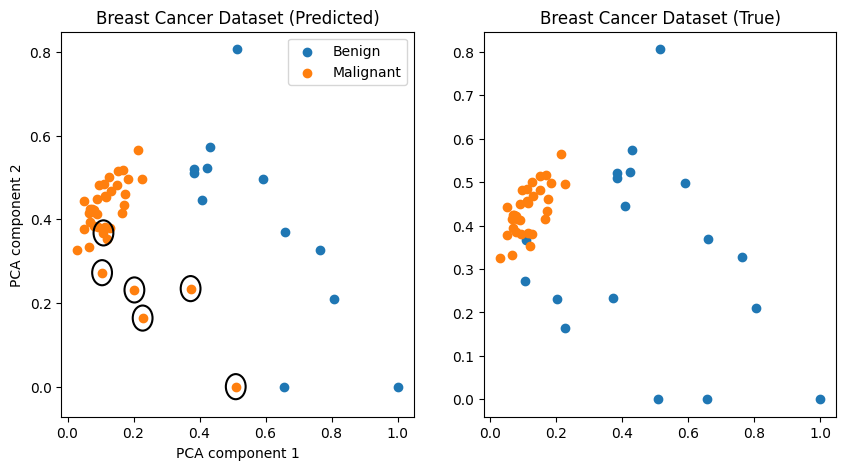

In [29]:
idx_misscls = np.arange(y_test.shape[0])[y_test_pred != y_test]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
x_axis_data = X_test_scaled[y_test_pred == 0, 0]
y_axis_data = X_test_scaled[y_test_pred == 0, 1]
ax1.scatter(x_axis_data, y_axis_data, label='Benign')

x_axis_data = X_test_scaled[y_test_pred == 1, 0]
y_axis_data = X_test_scaled[y_test_pred == 1, 1]
ax1.scatter(x_axis_data, y_axis_data, label='Malignant')

for idx in idx_misscls:
    circle = plt.Circle(X_test_scaled[idx,:], 0.03, color='black', fill=False, linewidth=1.5)
    ax1.add_patch(circle)

x_axis_data = X_test_scaled[y_test == 0, 0]
y_axis_data = X_test_scaled[y_test == 0, 1]
ax2.scatter(x_axis_data, y_axis_data, label='Benign')

x_axis_data = X_test_scaled[y_test == 1, 0]
y_axis_data = X_test_scaled[y_test == 1, 1]
ax2.scatter(x_axis_data, y_axis_data, label='Malignant')

ax1.set_title("Breast Cancer Dataset (Predicted)")
ax2.set_title("Breast Cancer Dataset (True)")
ax1.set_xlabel('PCA component 1')
ax1.set_ylabel('PCA component 2')
ax1.legend()
plt.show()

## Exercise: test different kernel architectures

In this example we have used a feature map with a rotation layer plus the ZZFeatureMap from Qiskit. You can try changing the embedding (angle/amplitude...) and variational model (different variational structures with more than one training parameter). Run some experiments and find the best kernel for this example. This may take a while to run, so you can reduce the number of samples to train the kernel alignment model.